In [9]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def estimateWhiteNoise(img):    
    # Normalize the image to range [0, 1]
    img = img / 255.0
    
    # Apply Gaussian blur to get a smoothed version of the image
    smoothed_img = cv2.GaussianBlur(img, (7, 7), 1.5)
    
    # Calculate the difference between the degraded image and the smoothed image
    difference = img - smoothed_img
    
    # Estimate the standard deviation of the noise
    noise_std = np.std(difference)
   
    return noise_std

# 加载退化图像
img1 = cv2.imread('pro2_satellite_1_degraded.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('pro2_satellite_2_degraded.tiff', cv2.IMREAD_GRAYSCALE)

# 估计噪声标准差
noise_std_dev1 = estimateWhiteNoise(img1)
noise_std_dev2 = estimateWhiteNoise(img2)

print(f'Estimated noise standard deviation for image 1: {noise_std_dev1}')
print(f'Estimated noise standard deviation for image 2: {noise_std_dev2}')


Estimated noise standard deviation for image 1: 0.002100120016878944
Estimated noise standard deviation for image 2: 0.0030447020987544654


In [10]:
def estimateGaussianImpulse(img):
    # Normalize the image to range [0, 1]
    img = img / 255.0
    
    # Fourier transform of the image
    img_ft = np.fft.fft2(img)
    img_ft_shifted = np.fft.fftshift(img_ft)
    
    # Take the magnitude and apply logarithm for better visualization
    magnitude_spectrum = np.log(np.abs(img_ft_shifted) + 1)
    
    # Find the peak in the Fourier domain
    center = np.array(magnitude_spectrum.shape) // 2
    y, x = np.indices(magnitude_spectrum.shape)
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Fit a Gaussian function to the magnitude spectrum
    sigma_est = np.mean(distance * magnitude_spectrum) / np.mean(magnitude_spectrum)
    
    return sigma_est

# Estimate Gaussian standard deviation
gaussian_std_dev1 = estimateGaussianImpulse(img1)
gaussian_std_dev2 = estimateGaussianImpulse(img2)

print(f'Estimated Gaussian standard deviation for image 1: {gaussian_std_dev1}')
print(f'Estimated Gaussian standard deviation for image 2: {gaussian_std_dev2}')

Estimated Gaussian standard deviation for image 1: 196.13832533100052
Estimated Gaussian standard deviation for image 2: 172.91269212316456


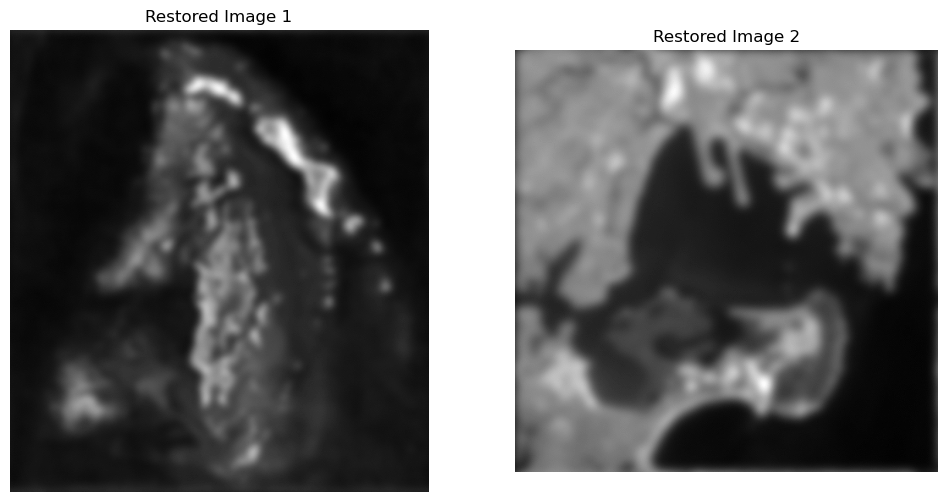

In [11]:
def create_gaussian_filter(shape, sigma):
    h, w = shape
    y, x = np.indices((h, w))
    center = np.array([h // 2, w // 2])
    gaussian_filter = np.exp(-((x - center[1])**2 + (y - center[0])**2) / (2 * sigma**2))
    return gaussian_filter

def inverseFilter(img, gaussian_std):
    # Normalize the image to range [0, 1]
    img = img / 255.0

    # Fourier transform of the image
    img_ft = np.fft.fft2(img)
    img_ft_shifted = np.fft.fftshift(img_ft)
    
    # Create the Gaussian filter in the frequency domain
    gaussian_filter = create_gaussian_filter(img.shape, gaussian_std)
    
    # Apply the inverse filter
    restored_img_ft_shifted = img_ft_shifted / (gaussian_filter + 1e-8)
    restored_img_ft = np.fft.ifftshift(restored_img_ft_shifted)
    restored_img = np.fft.ifft2(restored_img_ft)
    
    # Take the real part and normalize to [0, 255]
    restored_img = np.real(restored_img)
    restored_img = np.clip(restored_img * 255.0, 0, 255).astype(np.uint8)
    
    return restored_img

# Perform inverse filtering
restored_img1 = inverseFilter(img1, gaussian_std_dev1)
restored_img2 = inverseFilter(img2, gaussian_std_dev2)

# Display the restored images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Restored Image 1')
plt.imshow(restored_img1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Restored Image 2')
plt.imshow(restored_img2, cmap='gray')
plt.axis('off')

plt.show()


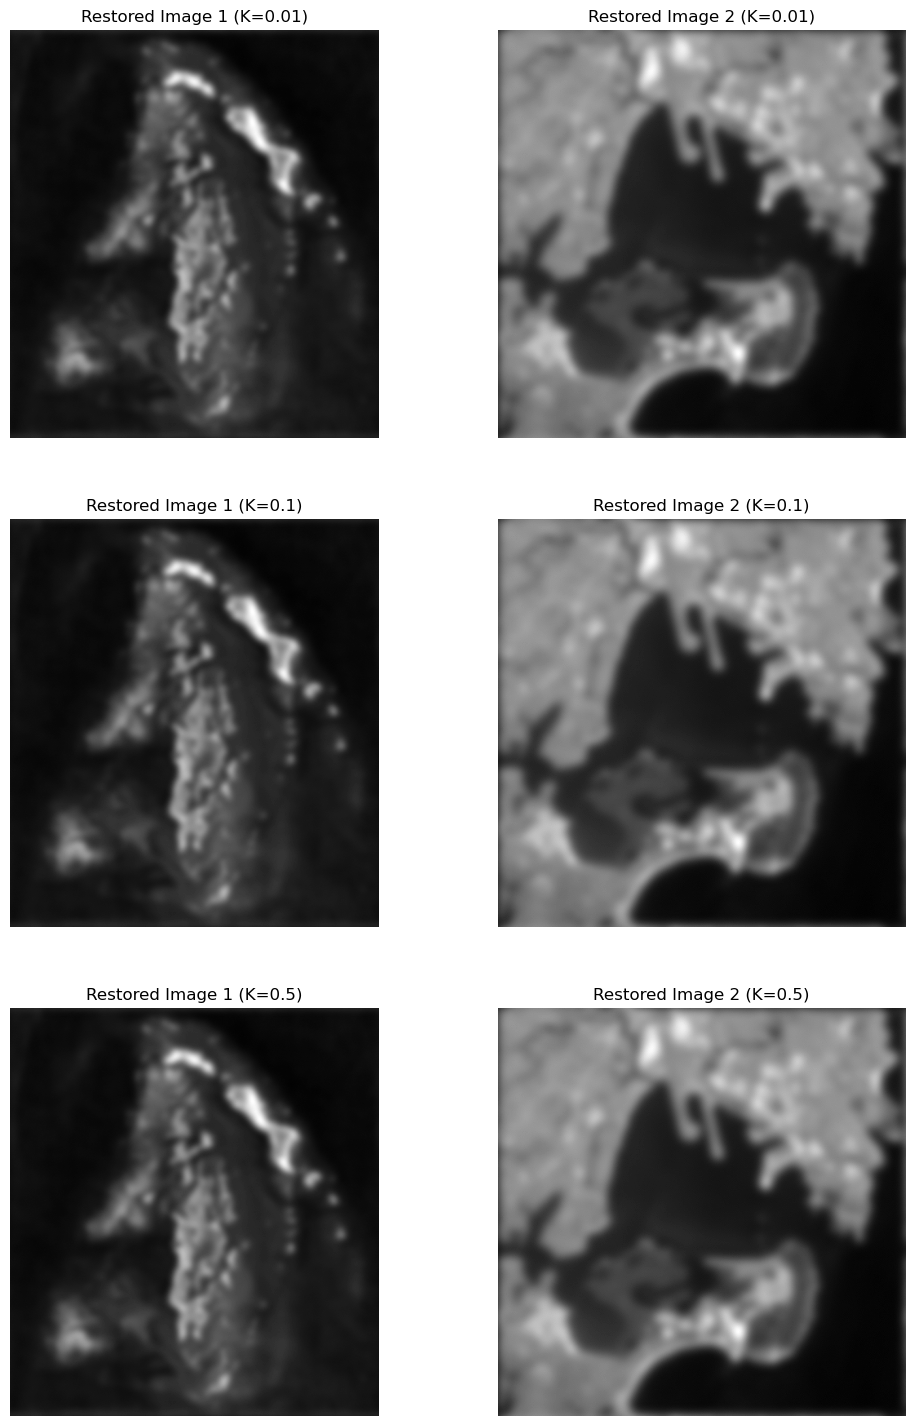

In [12]:
def wienerFilter(img, gaussian_std, noise_std, K):
    img = img / 255.0

    # fourier transform 
    img_ft = np.fft.fft2(img)
    img_ft_shifted = np.fft.fftshift(img_ft)
    
    # gaussian filter
    gaussian_filter = create_gaussian_filter(img.shape, gaussian_std)
    
    # wiener filter
    H_conj = np.conj(gaussian_filter)
    S_nn = noise_std**2
    S_yy = np.abs(gaussian_filter)**2
    wiener_filter = H_conj / (S_yy + K * S_nn)
    restored_img_ft_shifted = img_ft_shifted * wiener_filter
    restored_img_ft = np.fft.ifftshift(restored_img_ft_shifted)
    restored_img = np.fft.ifft2(restored_img_ft)
    
    # real part, normalize
    restored_img = np.real(restored_img)
    restored_img = np.clip(restored_img * 255.0, 0, 255).astype(np.uint8)
    
    return restored_img

K_values = [0.01, 0.1, 0.5]
restored_imgs1 = [wienerFilter(img1, gaussian_std_dev1, noise_std_dev1, K) for K in K_values]
restored_imgs2 = [wienerFilter(img2, gaussian_std_dev2, noise_std_dev2, K) for K in K_values]


plt.figure(figsize=(12, 18))
for i, K in enumerate(K_values):
    plt.subplot(3, 2, 2*i+1)
    plt.title(f'Restored Image 1 (K={K})')
    plt.imshow(restored_imgs1[i], cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    plt.title(f'Restored Image 2 (K={K})')
    plt.imshow(restored_imgs2[i], cmap='gray')
    plt.axis('off')

plt.show()
